# Введение в анализ данных
## НИУ ВШЭ, 2020-2021 учебный год

### Домашнее задание №8

In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

## Градиентный бустинг своими руками (2 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним основные формулы.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$. Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.

В качестве функции потерь возьмите MSE.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [3]:
# это может помочь вам для поиска оптимальных gamma
from scipy.optimize import minimize
from copy import copy

Так как в качестве функции потерь будет использоваться MSE $(L(y,z) = \frac{1}{2}\sum_{i=1}^l(y_i-z_i)^2)$, то найду её производную:
$$\frac{\partial L(y,z)}{\partial z_i} = -(y_i - z_i) = \{z_i = a_{N-1}(x_i)\} = -(y_i - a_{N-1}(x_i))$$
Таким образом, антиградиент функции потерь равен:
$$s_i = -(-(y_i - a_{N-1}(x_i))) = y_i - a_{N-1}(x_i)$$
То есть это просто остаток, поэтому в реализации "GradientBoosting" ниже буду использовать именно остатки.

In [4]:
class GradientBoosting:
    def __init__(self, n_estimators, max_depth, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        self._n_estimators = n_estimators
        self._max_depth = max_depth
        self._learning_rate = learning_rate
        self._gammas = []
        self._list_of_trees = []
        
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        # Здесь нам нужно проитерироваться по n_estimators и обучить
        # соответствующее количество деревьев с помощью _fit_predict_tree(),
        # правильно обновляя y_new
        # Деревья нужно где-то сохранить, чтобы затем использовать в predict()
        y_rest = copy(y.astype('float64'))
        for _ in range(self._n_estimators):
            # self._gammas.append(best_gamma(a_n=(y - y_new), b_n=))
            y_rest -= (self._fit_predict_tree(x, y_rest, y)).astype('float64')

    def _fit_predict_tree(self, x, y_rest, y):
        # Обучаем дерево и возвращаем его предикшн
        tree = DecisionTreeRegressor(max_depth=self._max_depth)
        tree.fit(x, y_rest)
        self._gammas.append(self.best_gamma(y=y, a_n=(y - y_rest), b_n=tree.predict(x)))
        self._list_of_trees.append(tree)
        return self._gammas[-1] * self._learning_rate * tree.predict(x)  # self._gamma * 
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        # Используем сохранённые деревья для расчёта агрегированного предикшна
        y_pred = np.zeros(x.shape[0])
        for i in range(self._n_estimators):
            y_pred += self._gammas[i] * self._learning_rate * self._list_of_trees[i].predict(x)
        return y_pred
    
    #@staticmethod
    def best_gamma(self, y, a_n, b_n):
        return (minimize(lambda x: np.sum((y - (a_n + x * b_n))**2), x0=1.1)).x


Проверьте вашу реализацию на Boston dataset. Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.

In [35]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [36]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

In [37]:
np.random.seed(19052019)

gb = GradientBoosting(n_estimators=1200, max_depth=6, learning_rate=0.01)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
mean_squared_error(y_test, y_pred)

10.461648141790471

Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- Да / Нет

ДААА

PS, ниже выведен вектор "оптимальных gamma" для каждого шага бустинга

In [9]:
gb._gammas

[array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([1.]),
 array([0.99999999]),
 array([0.99999999]),
 array([0.99999999]),
 array([1.]),
 array([0.99999999]),
 array([1.]),
 array([0.99999999]),
 array([0.99999997]),
 array([1.00000002]),
 array([0.99999996]),
 array([1.00000009]),
 array([0.99999999]),
 array([1.]),
 array([1.00000004]),
 array([0.99999999]),
 array([0.99999996]),
 array([1.00000003]),
 array([0.99999999]),
 array([1.00000003]),
 array([1.00000003]),
 array([1.00000001]),
 array([1.00000014]),
 array([0.99999992]),
 array([0.99999996]),
 array([1.00000005]),
 array([1.00000012]),
 array([0.99999985]),
 array([1.00000003]),
 array([1.00000003]),
 array([0.99999984]),
 array([0.99999996]),
 array([0.9999999]),
 array([1.00000001]),
 array([1.00000001]),
 array([0.99999994]),
 array([1.]),
 array([1.]),
 array([1.00000007]),
 array([1.]),
 array([1.00000033]),
 array([0.99999

In [10]:
for l_r in [0.005, 0.01, 0.05, 0.1]:
    for m_d in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
        for n_e in [400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600]:
            np.random.seed(19052019)
            gb = GradientBoosting(n_estimators=n_e, max_depth=m_d, learning_rate=l_r)
            gb.fit(X_train, y_train)
            print(str(l_r), str(m_d), str(n_e), ": ", mean_squared_error(y_test, gb.predict(X_test)))

0.005 1 400 :  34.35513359109103
0.005 1 500 :  26.413873460521202
0.005 1 600 :  23.06301555092794
0.005 1 700 :  21.32962301743351
0.005 1 800 :  20.2975633798563
0.005 1 900 :  19.57705208484316
0.005 1 1000 :  19.118245166783304
0.005 1 1100 :  18.761927750134113
0.005 1 1200 :  18.469201146414886
0.005 1 1300 :  18.290514123737086
0.005 1 1400 :  18.19829583804396
0.005 1 1500 :  18.15374722460183
0.005 1 1600 :  18.087773820432567
0.005 2 400 :  25.399298036479276
0.005 2 500 :  18.672690374761213
0.005 2 600 :  16.262167741132668
0.005 2 700 :  15.153702786301626
0.005 2 800 :  14.65028187252346
0.005 2 900 :  14.492155803793406
0.005 2 1000 :  14.555784176160449
0.005 2 1100 :  14.722896164496976
0.005 2 1200 :  14.895013436605218
0.005 2 1300 :  15.088911588192076
0.005 2 1400 :  15.28111338096729
0.005 2 1500 :  15.47989843535432
0.005 2 1600 :  15.63774387261379
0.005 3 400 :  21.880556179918973
0.005 3 500 :  15.42987716950873
0.005 3 600 :  12.946459107256969
0.005 3 700 :

0.01 9 1300 :  12.126352657490218
0.01 9 1400 :  12.12600433680398
0.01 9 1500 :  12.125872235172924
0.01 9 1600 :  12.125646780502375
0.01 10 400 :  13.162214606322879
0.01 10 500 :  13.021305680792171
0.01 10 600 :  13.011545712528598
0.01 10 700 :  13.009891092099958
0.01 10 800 :  13.008041757027131
0.01 10 900 :  13.008562034986133
0.01 10 1000 :  13.009421034710165
0.01 10 1100 :  13.009736247205788
0.01 10 1200 :  13.009958481862117
0.01 10 1300 :  13.009941455940188
0.01 10 1400 :  13.009931445569467
0.01 10 1500 :  13.009947303872048
0.01 10 1600 :  13.009945503772604
0.05 1 400 :  19.64576372971997
0.05 1 500 :  19.911927408441098
0.05 1 600 :  20.052265818479157
0.05 1 700 :  20.170962199934408
0.05 1 800 :  20.39460418737095
0.05 1 900 :  20.555455332725398
0.05 1 1000 :  20.674178527629415
0.05 1 1100 :  20.8485650035569
0.05 1 1200 :  20.87169511491991
0.05 1 1300 :  20.962614493760483
0.05 1 1400 :  21.07872540212537
0.05 1 1500 :  21.14094025456295
0.05 1 1600 :  21.333

0.1 8 1500 :  11.70416047104479
0.1 8 1600 :  11.70416047104479
0.1 9 400 :  11.78263194474563
0.1 9 500 :  11.782631938648619
0.1 9 600 :  11.782631938240467
0.1 9 700 :  11.78263193820922
0.1 9 800 :  11.782631938209025
0.1 9 900 :  11.782631938209093
0.1 9 1000 :  11.782631938209093
0.1 9 1100 :  11.782631938209093
0.1 9 1200 :  11.782631938209093
0.1 9 1300 :  11.782631938209093
0.1 9 1400 :  11.782631938209093
0.1 9 1500 :  11.782631938209093
0.1 9 1600 :  11.782631938209093
0.1 10 400 :  12.280438251582078
0.1 10 500 :  12.280438249337879
0.1 10 600 :  12.280438249270572
0.1 10 700 :  12.280438249269451
0.1 10 800 :  12.280438249269409
0.1 10 900 :  12.280438249269409
0.1 10 1000 :  12.280438249269409
0.1 10 1100 :  12.280438249269409
0.1 10 1200 :  12.280438249269409
0.1 10 1300 :  12.280438249269409
0.1 10 1400 :  12.280438249269409
0.1 10 1500 :  12.280438249269409
0.1 10 1600 :  12.280438249269409


Лучшие запуски по сетке получились:

0.005 6 1600 :  10.448855805321324

0.01 6 1400 :  10.294582484544033

0.01 7 1500 :  10.50387569822027

0.1 6 1300 :  10.039092771081318

Поэтому запущу ещё одну сетку:

In [11]:
for l_r in [0.16, 0.18, 0.2, 0.22, 0.24]:
    for m_d in [5, 6, 7]:
        for n_e in [400, 450, 500, 550, 600, 650]:
            np.random.seed(19052019)
            gb = GradientBoosting(n_estimators=n_e, max_depth=m_d, learning_rate=l_r)
            gb.fit(X_train, y_train)
            print(str(l_r), str(m_d), str(n_e), ": ", mean_squared_error(y_test, gb.predict(X_test)))

0.16 5 400 :  15.094413076363928
0.16 5 450 :  15.09428129382398
0.16 5 500 :  15.094118682314969
0.16 5 550 :  15.09413038069287
0.16 5 600 :  15.094128936422374
0.16 5 650 :  15.094133690548171
0.16 6 400 :  10.108003010739028
0.16 6 450 :  10.107994224352284
0.16 6 500 :  10.107994150272605
0.16 6 550 :  10.107993574219726
0.16 6 600 :  10.10799357271113
0.16 6 650 :  10.10799354791079
0.16 7 400 :  11.484583071834907
0.16 7 450 :  11.484583067084401
0.16 7 500 :  11.484583053607777
0.16 7 550 :  11.484583050256978
0.16 7 600 :  11.484583051556147
0.16 7 650 :  11.484583051468638
0.18 5 400 :  13.002397623548989
0.18 5 450 :  13.002414808593004
0.18 5 500 :  13.002369501427927
0.18 5 550 :  13.0023709441073
0.18 5 600 :  13.002366736913185
0.18 5 650 :  13.002366565180328
0.18 6 400 :  10.695395819269669
0.18 6 450 :  10.695395674697886
0.18 6 500 :  10.695395113644876
0.18 6 550 :  10.695395260953077
0.18 6 600 :  10.695395263801323
0.18 6 650 :  10.695395271291705
0.18 7 400 :  12

В итоге лучшим запуском оказался:

0.22 6 400 :  9.32176934555051

In [38]:
%%time
np.random.seed(19052019)
gb = GradientBoosting(n_estimators=400, max_depth=6, learning_rate=0.22)
gb.fit(X_train, y_train)
print(mean_squared_error(y_test, gb.predict(X_test)))

9.321769345550514
Wall time: 1.03 s


Этот результат превосходит результат рэндом фореста

## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {XGboost, catboost, LightGBM} и GridSearch для достижения результата. Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.

In [13]:
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_test.csv')

In [14]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [15]:
# Референс

from xgboost.sklearn import XGBClassifier

X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

xgb_model = XGBClassifier()
xgb_model.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb_model.predict_proba(X_valid)[:, 1])

C:\Users\Полина\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:18:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7036514504206617

In [16]:
X_train = train.drop('dep_delayed_15min', axis=1).values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

In [17]:
from catboost import CatBoostClassifier

In [18]:
reference = CatBoostClassifier()
reference.fit(X_train_part, y_train_part, silent=True, cat_features=[0,1,2,4,5,6])

In [19]:
roc_auc_score(y_valid, reference.predict_proba(X_valid)[:, 1])

0.7596305065659662

Даже при дефолтных параметрах результат получился лучше, чем 0.74

## DBSCAN своими руками (2 + 2* баллов)

DBSCAN: Density-based spatial clustering of applications with noise

Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


In [20]:
# Это может помочь вам для поиска дистанции между точками
from scipy.spatial.distance import pdist, cdist, squareform

In [21]:
class dbscan:
    def __init__(self, eps, min_samples):
        # your code here
        self._eps = eps
        self._min_samples = min_samples

    def fit_predict(self, X):
        # Помечаем переданные точки, чтобы отличать уже кластеризованные
        # или являющиеся шумом от остальных
        X = np.array(X)
        self._X = X
        labels = np.full((X.shape[0], 1), -1)  # "0" - необработанная точка, "-1" - шум, >= 1 - остальное
        self._max_label = -1
        # Реализуем цикл по точкам, игнорирущий уже кластеризованные
        # Если точка ещё не кластеризована, с помощью range_query() ищем её соседей
        # Если соседей недостаточно, то помечаем её выделенным под шум лейблом
        # (однако она ещё может попасть в какой-то иной кластер)
        # Если же соседей достаточно, будем строить от неё кластер с помощью grow_cluster()
        for i in range(X.shape[0]):
            if labels[i] == -1:
                neighbours = self.range_query(np.array(self._X[i]))
                if len(neighbours) >= self._min_samples:
                    cluster = self.grow_cluster(self._X[i], neighbours)
                    labels[cluster] = self._max_label + 1
                    self._max_label += 1
        self._labels = labels
        return labels

    def grow_cluster(self, root, neighbours):
        # В этой функции мы полностью строим кластер относительно переданной точки
        # Т.е. реализуем цикл по структуре данных, изначально состоящей из уже
        # известных соседей (neighbours) и в процессе пополняющейся
        # "соседями соседей" с помощью range_query()
        cluster = list(neighbours)
        neighbors_set = set(neighbours)
        for elem in cluster:
            new_neighbours = self.range_query(np.array(self._X[elem]))
            for i in range(len(new_neighbours)):
                if (new_neighbours[i] not in neighbors_set):  # если элемента ещё нет в очереди
                    cluster.append(new_neighbours[i])
                    neighbors_set.add(new_neighbours[i])
        return cluster

    def range_query(self, x):
        """Возвращает точки на расстоянии <= eps от x"""
        # С помощью функции dist()
        distances = self.dist(np.array([x]))
        mask = (distances < self._eps)
        # neighbours = X[mask]
        return np.where(mask==True)[1]  # mask.index(True)

    # @staticmethod
    def dist(self, x):
        """Метрика расстояния"""
        # Попробуйте что-нибудь из scipy.spatial.distance
        # Базовый вариант -- Евклидова метрика
        # mask = (self._X != -1)
        # undefined_points = self._X[mask]
        return cdist(x, self._X)

Проверим себя на простом примере:

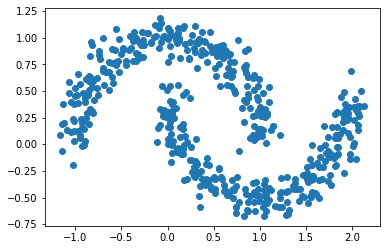

In [32]:
from sklearn.datasets import make_moons, make_circles, make_blobs
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(123)

X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:,0], X[:,1])
plt.show()

Кластеризуйте это с помощью своей версии DBSCAN:

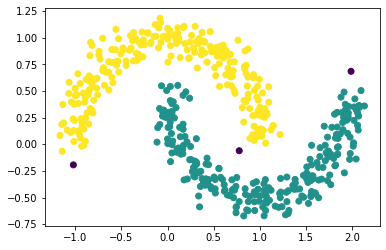

In [33]:
clusters = dbscan(eps=0.16, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Референс:

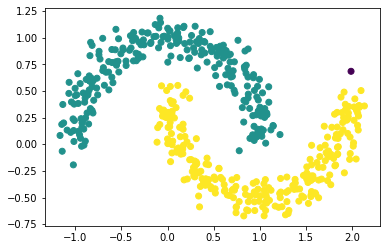

In [34]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Получите 1 балл за ещё один интересный пример кластеризации (в качестве референса используйте предоставленное изображение. Нужно несколько интересных соседствующих форм):

In [25]:
np.random.seed(12345)
x_1 = (5 + 5) * np.random.random(500) - 5
x_2 = (5 + 5) * np.random.random(500) - 5
y_1 = np.random.normal(np.cos(x_1), 0.25)
y_2 = np.random.normal(np.cos(x_2) + 2, 0.25)
x_moons_1, _ = make_moons(n_samples=100, noise=0.07)
x_moons_1[:,0] *= -1
x_moons_1[:,0] -= 1.5
x_moons_1[:,1] -= 3.5
x_moons_2, _ = make_moons(n_samples=100, noise=0.07)
x_moons_2[:,0] += 1.5
x_moons_2[:,1] -= 3.5
x_circles, _ = make_circles(n_samples=5000, noise=0.025)
x_circles[:,0] *= 8
x_circles[:,1] *= 8

In [26]:
dataset_x = np.hstack((x_1, x_2, x_moons_1[:,0], x_moons_2[:,0], x_circles[:,0]))
dataset_y = np.hstack((y_1, y_2, x_moons_1[:,1], x_moons_2[:,1], x_circles[:,1]))
dataset = np.vstack((dataset_x, dataset_y))
dataset = dataset.transpose()

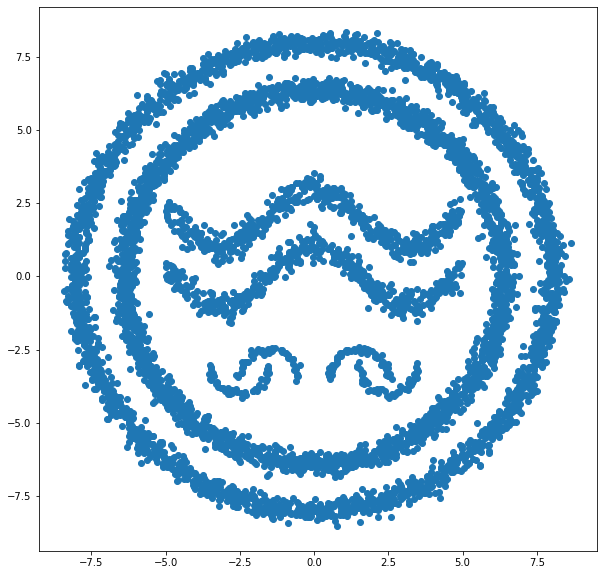

In [27]:
plt.figure(figsize = (10, 10))
plt.scatter(dataset[:,0], dataset[:,1])
plt.show()

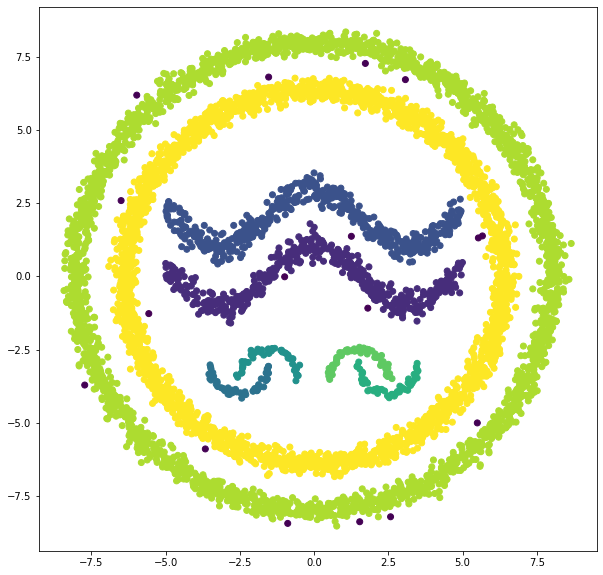

In [28]:
plt.figure(figsize = (10, 10))

clusters = dbscan(eps=0.3, min_samples=7).fit_predict(dataset)

plt.scatter(dataset[:,0], dataset[:,1], c=clusters)
plt.show()

Получите ещё 1 балл, если время работы вашего алгоритма больше референсного не более чем в 100 раз с учётом погрешности 3% от вашего времени:

In [29]:
%%time
%%capture
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

Wall time: 14 ms


In [30]:
%%time
%%capture
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

Wall time: 37.2 ms


Время работы алгоритма находится в пределах указанного значения